<a href="https://colab.research.google.com/github/DanielResearch/Identificacion-de-Durazno/blob/main/Entrenamiento_y_prueba_de_modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# General Setup

General SetUp son todas las librerías y funciones utilizadas, así como los métodos.

También se definen aquí los hiperparámetros (ver índice).

In [ ]:
!pip install yellowbrick

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, make_scorer, precision_score, recall_score, f1_score,accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV, cross_validate, KFold
from sklearn.model_selection import cross_val_score, StratifiedKFold,  StratifiedShuffleSplit
from sklearn.metrics import multilabel_confusion_matrix, precision_recall_fscore_support, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing  import StandardScaler, label_binarize
from sklearn import metrics
from time import time
from scipy import interp
from itertools import cycle
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from yellowbrick.model_selection import ValidationCurve

In [ ]:
def Metrics(y_truev,y_scored,n=6):
  return metrics.classification_report(y_true=y_truev,y_pred=y_scored,digits = n, output_dict= True)
  '''

In [ ]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [ ]:
scoring = {'prec_weighted': make_scorer(precision_score, average='macro'),
          'rec_weighted': make_scorer(recall_score, average='macro'),
          'f1_weighted': make_scorer(f1_score, average='macro'),
          'acc_weighted': make_scorer(accuracy_score)}

## Definir hiperparámetros para los modelos SVM RF y MLP

Hiperparámetros SVM

In [ ]:
param_rangeC = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

param_rangeGamma = [0.0001, 0.001, 0.01, 0.1, 1.0,10.0, 100.0, 1000.0]

param_grid_A = [{'svc__C': param_rangeC,'svc__gamma': param_rangeGamma,'svc__kernel': ['rbf']}]

param_grid_B = [{'svc__C': param_rangeC, 'svc__gamma': param_rangeGamma, 'svc__degree':[2] ,'svc__kernel': ['poly']} ]

## A) lineal rbf sigmoidal
## B) precomputed poly

Hiperparámetros RF

In [ ]:
n_estimators = [50, 100, 150, 200]
criterion = ['gini','entropy']
max_depth =  [5, 10, 15]

param_grid_rf ={'max_depth': max_depth,
                'n_estimators': n_estimators,
               'criterion': criterion}

Hiperparámetros MLP

In [ ]:
activation = ['relu','tanh']
hidden_layer_sizes = [(50,) , (100,), (150,), (200,) ]
solver = [ 'sgd', 'adam']
max_iter = [200,500]
alpha = [0.001, 0.01 ,0.1, 0.5]

param_grid_mlp_NEW  = {'mlpclassifier__activation': activation,
                'mlpclassifier__hidden_layer_sizes': hidden_layer_sizes,
               'mlpclassifier__solver': solver,
               'mlpclassifier__max_iter': max_iter,
               'mlpclassifier__alpha': alpha}

# Cargar conjunto de datos

El conjunto de datos esta dividido de la siguiente manera (por columnas)


0.   Clase (1-6)
1.   Cara
2.   H
3.   S
4.   V
5.   Ancho
6.   Alto
7.   Área
8.   Perímetro
9.   Redondez
10.   Excentricidad
11.   Proporción Ancho-Alto
12.   Hu $m_1$
13.  Hu $m_2$
14.  Hu $m_3$
15.  Hu $m_4$
16.  Hu $m_5$
17. Hu $m_6$
18. Hu $m_7$



Conjunto de datos 15K

In [3]:
dataSet = np.load('/content/drive/MyDrive/Paper2021/Datasets/Datos Morfologicos/VersionDosDerpuadoPorHSV/DataSetDepuradoVsAll_por_HSV_TotalDepurado_Todas_Características.npy')

In [4]:

dataSet.shape

(12734, 19)

## Distribución de los datos

### Clases 100%

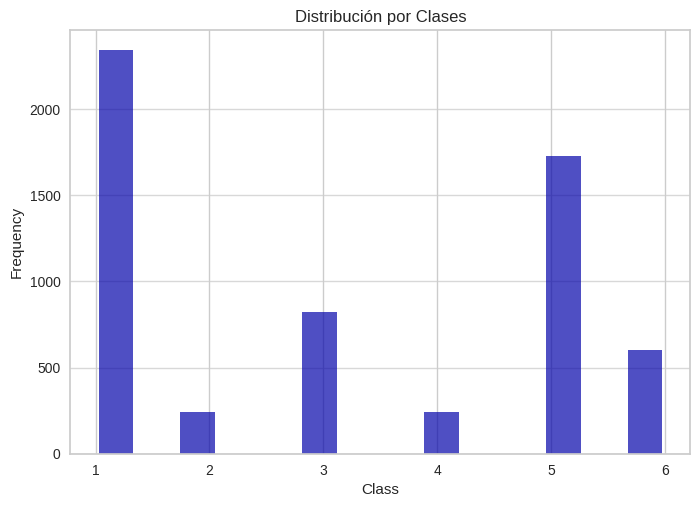

[2340.    0.  243.    0.    0.  825.    0.    0.  240.    0.    0. 1726.
    0.  602.]


In [5]:
n, bins, patches = plt.hist(x=dataSet[dataSet[:,1] == 1,0], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Distribución por Clases')
plt.show()
print(n)




# Creación de conjuntos de datos

vamos a trabajar con los colores HSV, redondez y excentricidad

In [7]:
dataSet2 = dataSet[dataSet[:,1] == 1,:]

C1 = dataSet2[dataSet2[:,0] == 1,2:5]  ## HSV
C1 = np.append( C1, dataSet2[dataSet2[:,0] == 1, 9:11 ], axis = 1 )  ## Redondez Excentricidad
YA = dataSet2[dataSet2[:,0] == 1,0]

C2 = dataSet2[dataSet2[:,0] == 2,2:5]
C2 = np.append( C2, dataSet2[dataSet2[:,0] == 2, 9:11 ], axis = 1 )
YA = np.append(YA,dataSet2[dataSet2[:,0] == 2,0])

C3 = dataSet2[dataSet2[:,0] == 3,2:5]
C3 = np.append( C3, dataSet2[dataSet2[:,0] == 3, 9:11 ], axis = 1 )
YA = np.append(YA,dataSet2[dataSet2[:,0] == 3,0])

C4 = dataSet2[dataSet2[:,0] == 4,2:5]
C4 = np.append( C4, dataSet2[dataSet2[:,0] == 4, 9:11 ], axis = 1 )
YA = np.append(YA,dataSet2[dataSet2[:,0] == 4,0])

C5 = dataSet2[dataSet2[:,0] == 5,2:5]
C5 = np.append( C5, dataSet2[dataSet2[:,0] == 5, 9:11 ], axis = 1 )
YA = np.append(YA,dataSet2[dataSet2[:,0] == 5,0])

C6 = dataSet2[dataSet2[:,0] == 6,2:5]
C6 = np.append( C6, dataSet2[dataSet2[:,0] == 6, 9:11 ], axis = 1 )
YA = np.append(YA,dataSet2[dataSet2[:,0] == 6,0])

XA = C1
XA = np.append(XA,C2, axis = 0)
XA = np.append(XA,C3, axis = 0)
XA = np.append(XA,C4, axis = 0)
XA = np.append(XA,C5, axis = 0)
XA = np.append(XA,C6, axis = 0)
YA = YA.astype(int)
print(XA.shape)
print(YA.shape)

(5976, 5)
(5976,)


In [ ]:
XA[0]

array([0.17881944, 0.7804878 , 0.48235294, 0.40765296, 0.95552422])

In [ ]:
YA.shape

(5976,)

In [ ]:
np.asarray([1, 6]).shape

(2,)

### Datos entrenamiento y test 80-20

In [8]:
x_trainA, x_testA, y_trainA, y_testA = train_test_split(XA,YA, test_size=0.2, stratify = YA , random_state=42)

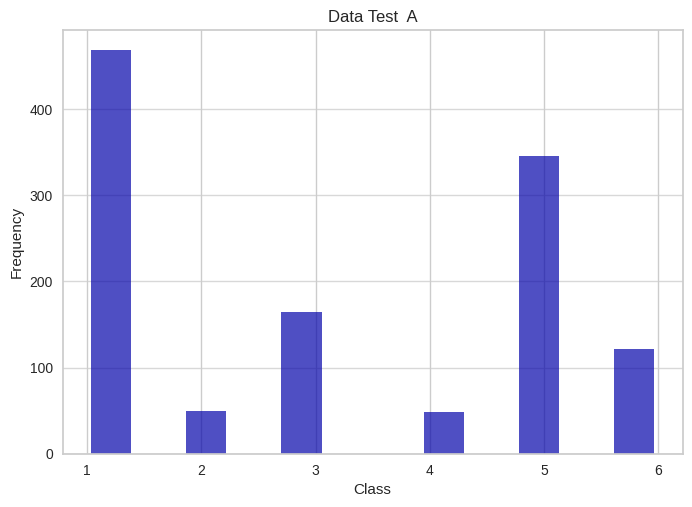

[468.   0.  49.   0. 165.   0.   0.  48.   0. 345.   0. 121.]


In [9]:
n, bins, patches = plt.hist(x=y_testA, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Data Test  A')
plt.show()
print(n)

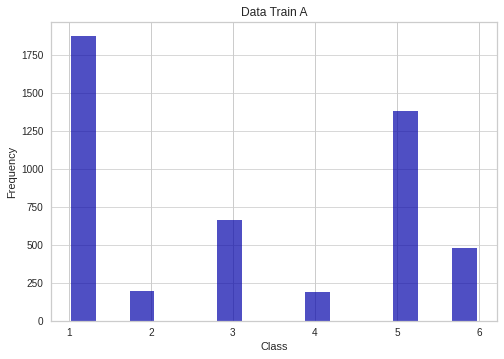

[1872.    0.  194.    0.    0.  660.    0.    0.  192.    0.    0. 1381.
    0.  481.]


In [ ]:
n, bins, patches = plt.hist(x=y_trainA, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Data Train A')
plt.show()
print(n)

### Datos 100

Se unen los dos conjuntos de datos x_trainA y x_testA

Para crear un solo conjunto de datos,  XA y YA para la validación cruzada k=10.

In [ ]:
XA = np.append(x_trainA,x_testA,axis=0)
YA = np.append(y_trainA,y_testA,axis=0)


Y_AUCROC = YA - 1
Y_AUCROC = label_binarize( Y_AUCROC, classes = np.asarray([0, 1, 2, 3, 4, 5]) )


print(YA.shape)
print(XA.shape)
print(Y_AUCROC.shape)

(5976,)
(5976, 5)
(5976, 6)


### Stratified Splits

Particiones de CV k=10

In [ ]:
cvA = StratifiedShuffleSplit(n_splits=10, random_state=42)
crossVA = cvA.split(XA,YA)

# **SVM A**

### GridSearch  80-20

In [ ]:
###cv=5
pipe_svc_1_91_A = make_pipeline(StandardScaler(),SVC(random_state=1))
gs_1_91_A = GridSearchCV(estimator=pipe_svc_1_91_A,param_grid=param_grid_A,scoring='accuracy',cv=5,n_jobs=-1)
start_time = time()
gs_1_91_A = gs_1_91_A.fit(x_trainA, y_trainA)
elapsed_time = time() - start_time
print("Tiempo transcurrido: %0.10f segundos." % elapsed_time)
print(gs_1_91_A.best_score_)
print(gs_1_91_A.best_params_)
paramSVCA = gs_1_91_A.best_params_

Tiempo transcurrido: 261.4637310505 segundos.
0.9763598326359834
{'svc__C': 100.0, 'svc__gamma': 1.0, 'svc__kernel': 'rbf'}


In [ ]:
paramSVCA = {'svc__C': 100.0, 'svc__gamma': 1.0, 'svc__kernel': 'rbf'}

In [ ]:
pred_A_1_Grid_91 = gs_1_91_A.predict(x_testA)
Metrics(y_testA.astype(int),pred_A_1_Grid_91.astype(int),n=6)

####  Cross_Validate

In [ ]:
#### cv = 10  100%
cvA = StratifiedShuffleSplit(n_splits=10, random_state=42)
crossVA = cvA.split(XA,YA)
start_time = time()
pipe_svc_K_91_A = make_pipeline(StandardScaler(),SVC(kernel=paramSVCA['svc__kernel'],random_state=1,gamma=paramSVCA['svc__gamma'], C = paramSVCA['svc__C']))
scores = cross_validate(estimator=pipe_svc_K_91_A,X=XA,y=YA, return_estimator= True ,scoring = scoring ,cv=crossVA,n_jobs=-1)
elapsed_time = time() - start_time
print("Tiempo transcurrido: %0.10f segundos." % elapsed_time)
#print('CV scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores['test_acc_weighted']),np.std(scores['test_acc_weighted'])))
print('CV f1: %.3f +/- %.3f' % (np.mean(scores['test_f1_weighted']),np.std(scores['test_f1_weighted'])))
print('CV prec: %.3f +/- %.3f' % (np.mean(scores['test_prec_weighted']),np.std(scores['test_prec_weighted'])))
print('CV rec: %.3f +/- %.3f' % (np.mean(scores['test_rec_weighted']),np.std(scores['test_rec_weighted'])))
print("\n\t\tAccuracy\n")
print(scores['test_acc_weighted'])
print("\n\t\t F1 \n")
print(scores['test_f1_weighted'])
print("\n\t\t Prec \n")
print(scores['test_prec_weighted'])
print("\n\t\t Rec \n")
print(scores['test_rec_weighted'])

Tiempo transcurrido: 4.8295016289 segundos.
CV accuracy: 0.987 +/- 0.004
CV f1: 0.980 +/- 0.006
CV prec: 0.984 +/- 0.006
CV rec: 0.976 +/- 0.008

		Accuracy

[0.98494983 0.98327759 0.98494983 0.98662207 0.98327759 0.9916388
 0.99498328 0.98160535 0.98662207 0.98829431]

		 F1 

[0.97977925 0.97916312 0.98585833 0.98166735 0.96991614 0.98220635
 0.98941482 0.96956193 0.97858247 0.98398335]

		 Prec 

[0.98283921 0.98909011 0.98123074 0.98474143 0.97109397 0.98976697
 0.99432024 0.97795501 0.98467975 0.98659272]

		 Rec 

[0.97698687 0.97004243 0.99074704 0.97874376 0.9687704  0.97619524
 0.98514772 0.96205334 0.97279832 0.98180829]


Matríz de confusión acumulado

In [ ]:
i=0
cvA = StratifiedShuffleSplit(n_splits=10, random_state=42)
crossVA = cvA.split(XA,YA)
acumulado = 0
for train_index, test_index in crossVA:
  model_91_A = make_pipeline(StandardScaler(), SVC(kernel=paramSVCA['svc__kernel'],random_state=1,gamma=paramSVCA['svc__gamma'], C = paramSVCA['svc__C']))
  model_91_A.fit(XA[train_index],YA[train_index])
  pred_model_91_A =  model_91_A.predict(XA[test_index])
  print("\t\t\t K="+str(i))
  Metrics(YA[test_index].astype(int),pred_model_91_A.astype(int),6)
  suma = metrics.confusion_matrix(y_true=YA[test_index].astype(int),y_pred=pred_model_91_A.astype(int))
  acumulado = acumulado + suma
  i+=1
  print(acumulado)

			 K=0

Matriz de Confusión

[[231   0   1   1   1   0]
 [  1  23   0   0   0   0]
 [  0   0  80   0   3   0]
 [  0   0   0  23   1   0]
 [  0   0   0   0 172   1]
 [  0   0   0   0   0  60]]

 Reporte de Métricas de Clasificación 

              precision    recall  f1-score   support

           1   0.995690  0.987179  0.991416       234
           2   1.000000  0.958333  0.978723        24
           3   0.987654  0.963855  0.975610        83
           4   0.958333  0.958333  0.958333        24
           5   0.971751  0.994220  0.982857       173
           6   0.983607  1.000000  0.991736        60

    accuracy                       0.984950       598
   macro avg   0.982839  0.976987  0.979779       598
weighted avg   0.985110  0.984950  0.984941       598

[[231   0   1   1   1   0]
 [  1  23   0   0   0   0]
 [  0   0  80   0   3   0]
 [  0   0   0  23   1   0]
 [  0   0   0   0 172   1]
 [  0   0   0   0   0  60]]
			 K=1

Matriz de Confusión

[[231   0   2   0   1   0]
 [ 

Obtención de promedios por métrica

In [ ]:
i=0
cvA = StratifiedShuffleSplit(n_splits=10, random_state=42)
crossVA = cvA.split(XA,YA)
acumulado1 = []
acumulado2 = []
acumulado3 = []
acumulado4 = []
acumulado5 = []
acumulado6 = []
for train_index, test_index in crossVA:
  model_91_A = make_pipeline(StandardScaler(), SVC(kernel=paramSVCA['svc__kernel'],random_state=1,gamma=paramSVCA['svc__gamma'], C = paramSVCA['svc__C']))
  model_91_A.fit(XA[train_index],YA[train_index])
  pred_model_91_A =  model_91_A.predict(XA[test_index])
  print("\t\t\t K="+str(i))
  dic = Metrics(YA[test_index].astype(int),pred_model_91_A.astype(int),6)
  ### diccionario 'f1-score', 'recall', 'precision'
  acumulado1.append(dic['1']['precision'])
  acumulado2.append(dic['2']['precision'])
  acumulado3.append(dic['3']['precision'])
  acumulado4.append(dic['4']['precision'])
  acumulado5.append(dic['5']['precision'])
  acumulado6.append(dic['6']['precision'])
  i+=1
  print("\n\n")


			 K=0



			 K=1



			 K=2



			 K=3



			 K=4



			 K=5



			 K=6



			 K=7



			 K=8



			 K=9





In [ ]:
array_acumulado_1 = np.asarray(acumulado1)
array_acumulado_2 = np.asarray(acumulado2)
array_acumulado_3 = np.asarray(acumulado3)
array_acumulado_4 = np.asarray(acumulado4)
array_acumulado_5 = np.asarray(acumulado5)
array_acumulado_6 = np.asarray(acumulado6)

print('clase 1')
print('CV : %.6f +/- %.6f' % (np.mean(array_acumulado_1),np.std(array_acumulado_1)))
print('clase 2')
print('CV : %.6f +/- %.6f' % (np.mean(array_acumulado_2),np.std(array_acumulado_2)))
print('clase 3')
print('CV : %.6f +/- %.6f' % (np.mean(array_acumulado_3),np.std(array_acumulado_3)))
print('clase 4')
print('CV : %.6f +/- %.6f' % (np.mean(array_acumulado_4),np.std(array_acumulado_4)))
print('clase 5')
print('CV : %.6f +/- %.6f' % (np.mean(array_acumulado_5),np.std(array_acumulado_5)))
print('clase 6')
print('CV : %.6f +/- %.6f' % (np.mean(array_acumulado_6),np.std(array_acumulado_6)))

clase 1
CV : 0.992736 +/- 0.004689
clase 2
CV : 0.975319 +/- 0.027465
clase 3
CV : 0.980814 +/- 0.015836
clase 4
CV : 0.982955 +/- 0.020902
clase 5
CV : 0.981791 +/- 0.008237
clase 6
CV : 0.991771 +/- 0.010946


# **RANDOM FOREST A**

### GridSearch 80-20

In [ ]:
RF_91_A =  RandomForestClassifier(random_state = 42)

gs_RF_91_A = GridSearchCV(estimator=RF_91_A,param_grid=param_grid_rf,scoring='accuracy',cv=5,n_jobs=-1)
start_time = time()
gs_RF_91_A = gs_RF_91_A.fit(x_trainA, y_trainA)
elapsed_time = time() - start_time
print("Tiempo transcurrido: %0.10f segundos." % elapsed_time)
print(gs_RF_91_A.best_score_)
print(gs_RF_91_A.best_params_)
paramRFA = gs_RF_91_A.best_params_

Tiempo transcurrido: 70.5536043644 segundos.
0.9845188284518829
{'criterion': 'entropy', 'max_depth': 15, 'n_estimators': 100}


In [ ]:
pred_RF_Grid_91_A = gs_RF_91_A.predict(x_testA)
Metrics(y_testA.astype(int),pred_RF_Grid_91_A.astype(int),6)


Matriz de Confusión

[[465   1   2   0   0   0]
 [  2  45   0   1   0   1]
 [  3   0 160   0   2   0]
 [  1   0   0  46   0   1]
 [  0   0   0   0 345   0]
 [  0   0   0   1   1 119]]

 Reporte de Métricas de Clasificación 

              precision    recall  f1-score   support

           1   0.987261  0.993590  0.990415       468
           2   0.978261  0.918367  0.947368        49
           3   0.987654  0.969697  0.978593       165
           4   0.958333  0.958333  0.958333        48
           5   0.991379  1.000000  0.995671       345
           6   0.983471  0.983471  0.983471       121

    accuracy                       0.986622      1196
   macro avg   0.981060  0.970576  0.975642      1196
weighted avg   0.986590  0.986622  0.986547      1196



####  Cross_Validate

In [ ]:
#### cv = 10  100%
cvA = StratifiedShuffleSplit(n_splits=10, random_state=42)
crossVA = cvA.split(x_trainA,y_trainA)
kf_RF_91_A = RandomForestClassifier(criterion=paramRFA['criterion'],max_depth= paramRFA['max_depth'], n_estimators = paramRFA['n_estimators'] ,random_state = 42)
start_time = time()
scores = cross_validate(estimator=kf_RF_91_A ,X=x_trainA,y=y_trainA, scoring = scoring, return_estimator= True ,cv = crossVA,n_jobs=-1)
elapsed_time = time() - start_time
print("Tiempo transcurrido: %0.10f segundos." % elapsed_time)
#print('CV scores: %s' % scores)
print('CV accuracy: %.6f +/- %.6f' % (np.mean(scores['test_acc_weighted']),np.std(scores['test_acc_weighted'])))
print('CV f1: %.6f +/- %.6f' % (np.mean(scores['test_f1_weighted']),np.std(scores['test_f1_weighted'])))
print('CV prec: %.6f +/- %.6f' % (np.mean(scores['test_prec_weighted']),np.std(scores['test_prec_weighted'])))
print('CV rec: %.6f +/- %.6f' % (np.mean(scores['test_rec_weighted']),np.std(scores['test_rec_weighted'])))
print("\n\t\tAccuracy\n")
print(scores['test_acc_weighted'])
print("\n\t\t F1 \n")
print(scores['test_f1_weighted'])
print("\n\t\t Prec \n")
print(scores['test_prec_weighted'])
print("\n\t\t Rec \n")
print(scores['test_rec_weighted'])


Tiempo transcurrido: 7.0413997173 segundos.
CV accuracy: 0.986611 +/- 0.008167
CV f1: 0.979833 +/- 0.014417
CV prec: 0.987472 +/- 0.009496
CV rec: 0.973607 +/- 0.018312

		Accuracy

[0.9790795  0.98953975 0.9874477  0.96861925 0.9832636  0.99790795
 0.9958159  0.98535565 0.98535565 0.99372385]

		 F1 

[0.96759264 0.99003217 0.97519481 0.9460982  0.97587089 0.99512481
 0.99302419 0.97669616 0.98430682 0.99438435]

		 Prec 

[0.97946762 0.99098995 0.98553772 0.96463715 0.98553314 0.99880096
 0.99761905 0.98663963 0.99067227 0.99482559]

		 Rec 

[0.95838254 0.98943237 0.96742598 0.93142136 0.96741523 0.99166667
 0.98870282 0.96916976 0.97839756 0.99405823]


Valores acumulados de CV Matriz de confusión

In [ ]:
i=0
cvA = StratifiedShuffleSplit(n_splits=10, random_state=42)
crossVA = cvA.split(x_trainA,y_trainA)
acumulado = 0
for train_index, test_index in crossVA:
  #Modelo_rf_91_A = RandomForestClassifier(criterion=paramRFA['criterion'],max_depth= paramRFA['max_depth'], n_estimators = paramRFA['n_estimators'] ,random_state = 42)
  Modelo_rf_91_A = RandomForestClassifier(criterion='entropy',max_depth= 20, n_estimators = 150 ,random_state = 42)
  Modelo_rf_91_A.fit(x_trainA[train_index],y_trainA[train_index])
  pred_model_rf_91_A =  Modelo_rf_91_A.predict(x_trainA[test_index])
  print("\t\t\t K="+str(i))
  #suma = Metrics(YA[test_index].astype(int),pred_model_rf_91_A.astype(int),6)
  suma = metrics.confusion_matrix(y_true=y_trainA[test_index].astype(int),y_pred=pred_model_rf_91_A.astype(int))
  acumulado = acumulado + suma
  i+=1
  print("\n\n")
print(acumulado)

			 K=0



			 K=1



			 K=2



			 K=3



			 K=4



			 K=5



			 K=6



			 K=7



			 K=8



			 K=9



[[1862    0    2    0    3    3]
 [   0  198    0    0    2    0]
 [   8    0  645    0    6    1]
 [   0    0    0  175    9    6]
 [   5    1    5    1 1366    2]
 [   1    0    2    0    5  472]]


Obtención del promedio por clase de cada métrica

In [ ]:
i=0
cvA = StratifiedShuffleSplit(n_splits=10, random_state=42)
crossVA = cvA.split(XA,YA)
acumulado1 = []
acumulado2 = []
acumulado3 = []
acumulado4 = []
acumulado5 = []
acumulado6 = []
for train_index, test_index in crossVA:
  Modelo_rf_91_A = RandomForestClassifier(criterion=paramRFA['criterion'],max_depth= paramRFA['max_depth'], n_estimators = paramRFA['n_estimators'] ,random_state = 42)
  Modelo_rf_91_A.fit(XA[train_index],YA[train_index])
  pred_model_rf_91_A =  Modelo_rf_91_A.predict(XA[test_index])
  print("\t\t\t K="+str(i))
  dic = Metrics(YA[test_index].astype(int),pred_model_rf_91_A.astype(int),6)
  ### diccionario 'f1-score', 'recall', 'precision'
  acumulado1.append(dic['1']['f1-score'])
  acumulado2.append(dic['2']['f1-score'])
  acumulado3.append(dic['3']['f1-score'])
  acumulado4.append(dic['4']['f1-score'])
  acumulado5.append(dic['5']['f1-score'])
  acumulado6.append(dic['6']['f1-score'])
  i+=1
  print("\n\n")


In [ ]:
array_acumulado_1 = np.asarray(acumulado1)
array_acumulado_2 = np.asarray(acumulado2)
array_acumulado_3 = np.asarray(acumulado3)
array_acumulado_4 = np.asarray(acumulado4)
array_acumulado_5 = np.asarray(acumulado5)
array_acumulado_6 = np.asarray(acumulado6)

print('clase 1')
print('CV : %.6f +/- %.6f' % (np.mean(array_acumulado_1),np.std(array_acumulado_1)))
print('clase 2')
print('CV : %.6f +/- %.6f' % (np.mean(array_acumulado_2),np.std(array_acumulado_2)))
print('clase 3')
print('CV : %.6f +/- %.6f' % (np.mean(array_acumulado_3),np.std(array_acumulado_3)))
print('clase 4')
print('CV : %.6f +/- %.6f' % (np.mean(array_acumulado_4),np.std(array_acumulado_4)))
print('clase 5')
print('CV : %.6f +/- %.6f' % (np.mean(array_acumulado_5),np.std(array_acumulado_5)))
print('clase 6')
print('CV : %.6f +/- %.6f' % (np.mean(array_acumulado_6),np.std(array_acumulado_6)))

# **MLP A**

### GridSearch 80-20

In [ ]:
MLP_91_A = make_pipeline(StandardScaler(),MLPClassifier(random_state = 42))

gs_MLP_91_A = GridSearchCV(estimator=MLP_91_A,param_grid=param_grid_mlp_NEW,scoring='accuracy',cv=5,n_jobs=-1)
start_time = time()
gs_MLP_91_A = gs_MLP_91_A.fit(x_trainA, y_trainA)
elapsed_time = time() - start_time
print("Tiempo transcurrido: %0.10f segundos." % elapsed_time)
print(gs_MLP_91_A.best_score_)
print(gs_MLP_91_A.best_params_)
paramMLPA = gs_MLP_91_A.best_params_

Tiempo transcurrido: 2996.1965203285 segundos.
0.9573221757322175
{'mlpclassifier__activation': 'relu', 'mlpclassifier__alpha': 0.001, 'mlpclassifier__hidden_layer_sizes': (150,), 'mlpclassifier__max_iter': 500, 'mlpclassifier__solver': 'adam'}


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [ ]:
paramMLPA = {'mlpclassifier__activation': 'relu', 'mlpclassifier__alpha': 0.001, 'mlpclassifier__hidden_layer_sizes': (200,), 'mlpclassifier__max_iter': 1000, 'mlpclassifier__solver': 'adam'}

In [ ]:
pred_MLP_Grid_91_A = gs_MLP_91_A.predict(x_testA)
Metrics(y_testA.astype(int),pred_MLP_Grid_91_A.astype(int),4)


Matriz de Confusión

[[458   0   5   0   4   1]
 [  1  47   0   1   0   0]
 [  9   0 150   2   3   1]
 [  1   0   0  43   2   2]
 [  1   1   3   0 337   3]
 [  0   2   1   0   0 118]]

 Reporte de Métricas de Clasificación 

              precision    recall  f1-score   support

           1     0.9745    0.9786    0.9765       468
           2     0.9400    0.9592    0.9495        49
           3     0.9434    0.9091    0.9259       165
           4     0.9348    0.8958    0.9149        48
           5     0.9740    0.9768    0.9754       345
           6     0.9440    0.9752    0.9593       121

    accuracy                         0.9640      1196
   macro avg     0.9518    0.9491    0.9503      1196
weighted avg     0.9640    0.9640    0.9639      1196



####  Cross_Validate

In [ ]:
#### cv = 10  100%
cvA = StratifiedShuffleSplit(n_splits=10, random_state=42)
crossVA = cvA.split(XA,YA)
kf_MLP_91_A =  make_pipeline(StandardScaler(),MLPClassifier(alpha=paramMLPA['mlpclassifier__alpha'], hidden_layer_sizes=paramMLPA['mlpclassifier__hidden_layer_sizes'],activation=paramMLPA['mlpclassifier__activation'],max_iter=paramMLPA['mlpclassifier__max_iter'],solver=paramMLPA['mlpclassifier__solver'],random_state = 42))
start_time = time()
scores = cross_validate(estimator=kf_MLP_91_A ,X=XA,y=YA, scoring = scoring, return_estimator= True ,cv=crossVA,n_jobs=-1)
elapsed_time = time() - start_time
print("Tiempo transcurrido: %0.10f segundos." % elapsed_time)
#print('CV scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores['test_acc_weighted']),np.std(scores['test_acc_weighted'])))
print('CV f1: %.3f +/- %.3f' % (np.mean(scores['test_f1_weighted']),np.std(scores['test_f1_weighted'])))
print('CV prec: %.3f +/- %.3f' % (np.mean(scores['test_prec_weighted']),np.std(scores['test_prec_weighted'])))
print('CV rec: %.3f +/- %.3f' % (np.mean(scores['test_rec_weighted']),np.std(scores['test_rec_weighted'])))
print("\n\t\tAccuracy\n")
print(scores['test_acc_weighted'])
print("\n\t\t F1 \n")
print(scores['test_f1_weighted'])
print("\n\t\t Prec \n")
print(scores['test_prec_weighted'])
print("\n\t\t Rec \n")
print(scores['test_rec_weighted'])

Tiempo transcurrido: 88.2797596455 segundos.
CV accuracy: 0.970 +/- 0.004
CV f1: 0.958 +/- 0.008
CV prec: 0.966 +/- 0.008
CV rec: 0.951 +/- 0.009

		Accuracy

[0.97324415 0.96822742 0.96822742 0.97826087 0.97324415 0.97157191
 0.97157191 0.96488294 0.97157191 0.9632107 ]

		 F1 

[0.95834343 0.95953878 0.96378525 0.9732431  0.95216028 0.96604148
 0.95249544 0.9413389  0.96105196 0.95467827]

		 Prec 

[0.96755193 0.9672472  0.96434919 0.98062342 0.96313818 0.9750504
 0.96249005 0.94942257 0.97349033 0.95965495]

		 Rec 

[0.95021069 0.95251993 0.96338546 0.96637061 0.94216411 0.95862527
 0.94508806 0.93496223 0.94978519 0.95118853]
